In [1]:
from UTILITY_quickstart import *
?initializeTao

Signature:
initializeTao(
    filePath=None,
    lastTrackedElement='end',
    csrTF=False,
    inputBeamFilePathSuffix=None,
    numMacroParticles=None,
    loadDefaultLatticeTF=True,
    runImpactTF=False,
    impactGridCount=32,
)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [2]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    csrTF = True,
    #numMacroParticles=1e3,
    #loadDefaultLatticeTF=False,

)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles defined by input file


In [3]:
trackBeam(tao)

In [4]:
savedData = {}

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)


for PActiveStr in ["PDrive", "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "sigma_x", "sigma_y"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

In [5]:
savedData

{'PDrive_mean_x': -3.445018304347051e-05,
 'PDrive_mean_y': -2.0464013861516044e-07,
 'PDrive_sigma_x': 5.461124742381961e-05,
 'PDrive_sigma_y': 3.06017986237548e-05,
 'PDrive_xCost': 6.456936933960455e-05,
 'PDrive_yCost': 3.060248285017366e-05,
 'PDrive_totalCost': 4.75859260948891e-05,
 'PDrive_emitSI90_x': 4.622600457770599e-05,
 'PDrive_emitSI90_y': 6.779741323391151e-06,
 'PDrive_zLen': 1.8578285229678127e-05,
 'PDrive_zCentroid': 991.3316948264711,
 'PWitness_mean_x': 1.2276597578294781e-06,
 'PWitness_mean_y': 2.2469914470808075e-07,
 'PWitness_sigma_x': 6.051703316279178e-05,
 'PWitness_sigma_y': 2.6733282110472674e-05,
 'PWitness_xCost': 6.05294841486976e-05,
 'PWitness_yCost': 2.6734226416781745e-05,
 'PWitness_totalCost': 4.3631855282739674e-05,
 'PWitness_emitSI90_x': 0.00011783698492087527,
 'PWitness_emitSI90_y': 1.669012395591888e-05,
 'PWitness_zLen': 8.946293768210196e-06,
 'PWitness_zCentroid': 991.3318391795196,
 'bunchSpacing': 0.00014435304854032438}

In [6]:
print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2) :.3g} um""")

print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad, 90% charge implied""")
print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad, 90% charge implied""")

print(f"""Driver sigma_z: \t{1e6 * savedData["PDrive_zLen"] :.3g} um, 90% charge implied""")
print(f"""Witness sigma_z: \t{1e6 * savedData["PWitness_zLen"] :.3g} um, 90% charge implied""")

Bunch spacing: 		144 um
Transverse offset: 	35.7 um
Driver emittance: 	46.2 × 6.78 um-rad, 90% charge implied
Witness emittance: 	118 × 16.7 um-rad, 90% charge implied
Driver sigma_z: 	18.6 um, 90% charge implied
Witness sigma_z: 	8.95 um, 90% charge implied


In [7]:
# optimizer = bayes_opt.BayesianOptimization(
#     f=problem.optimizerWrapper,
#     pbounds=pbounds,
#     random_state=7,
#     allow_duplicate_points=True, #2024-04-26 it was whining about this,
#     verbose = 0 #2024-05-22: Make it quiet
# )

# #Initial point(s) to check
# optimizer.probe(
#     params={
# 'Q1EkG': 117.05888832887702,
#  'Q2EkG': -161.08070347179788,
#  'Q3EkG': 123.62696608961151,
#  'Q4EkG': 99.94203817364581,
#  'Q5EkG': -31.456534919110677,
#  'Q6EkG': -105.01493924928589,
#  'S1ELkG': 453.142910378237,
#  'S2ELkG': -1988.4701652598128,
#  'S3ELkG': -985.7586439934659,
#  'S3ERkG': -564.5394965036853,
#  'S2ERkG': -1592.1135118613981,
#  'S1ERkG': 869.2610562040793
# },
#     lazy=True,
# )

# #Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
# #and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
# boInitialKappa = 10 + 0*10.
# boFinalKappa = 1e-3 + 0*0.1
# boNumIter = 1000
# boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

# acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
#                                    kappa=boInitialKappa,         #Default 2.576
#                                    xi=0.0,              #Default 0
#                                    kappa_decay=boKappaDecay,       #Default 0
#                                    kappa_decay_delay=0  #Default 0                     
#                                           )


# optimizer.maximize(
#     init_points=0, #Initial, random points
#     n_iter=boNumIter,
#     acquisition_function=acquisition_function
# )

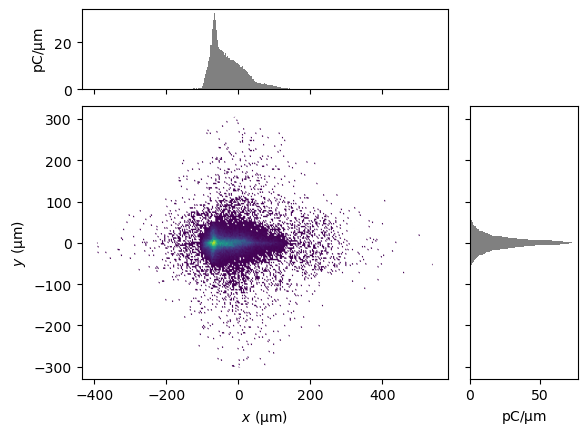

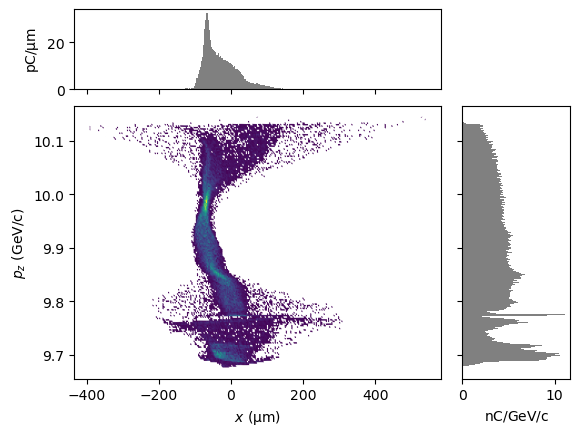

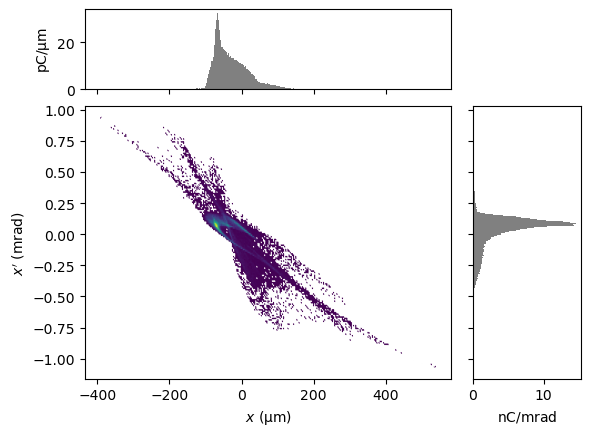

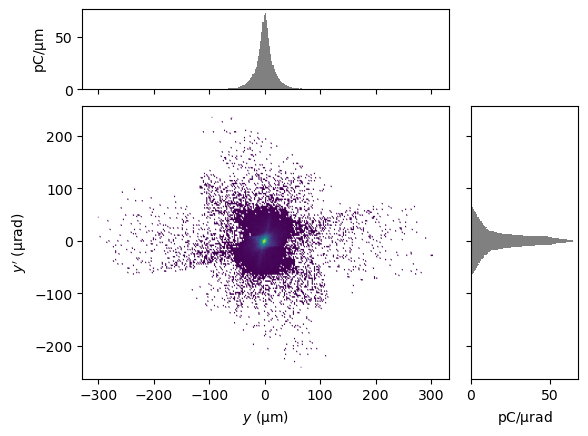

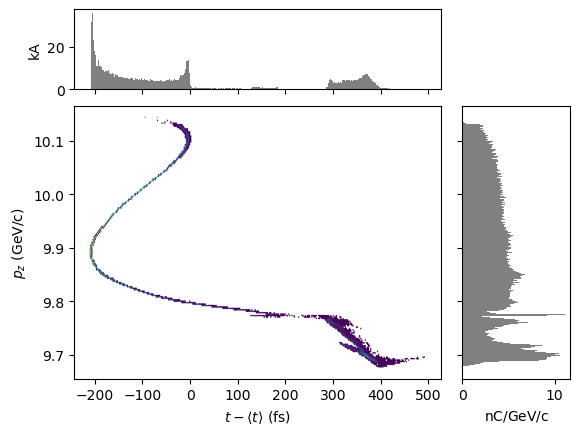

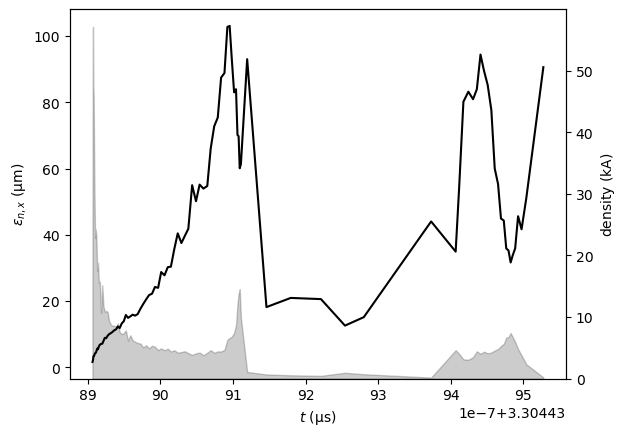

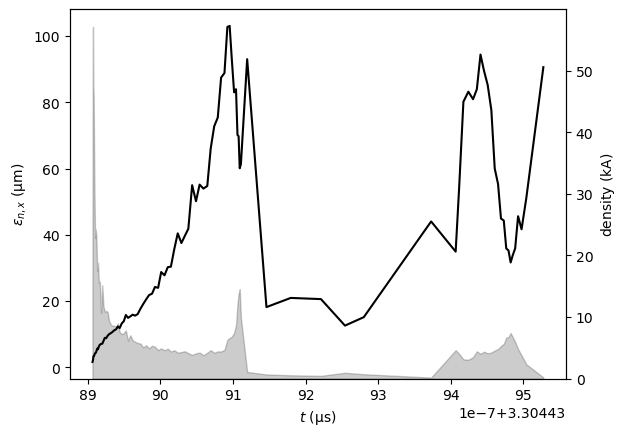

In [8]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'delta_t', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))


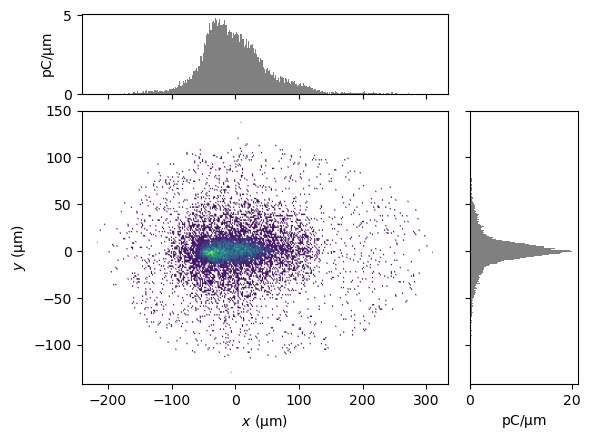

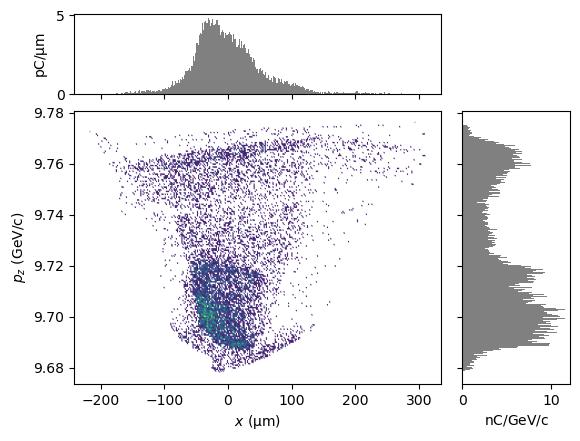

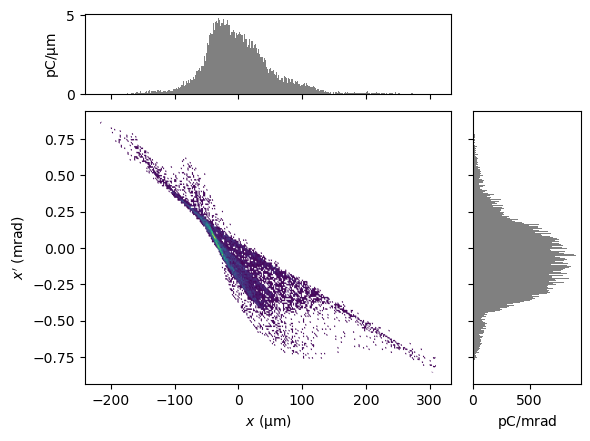

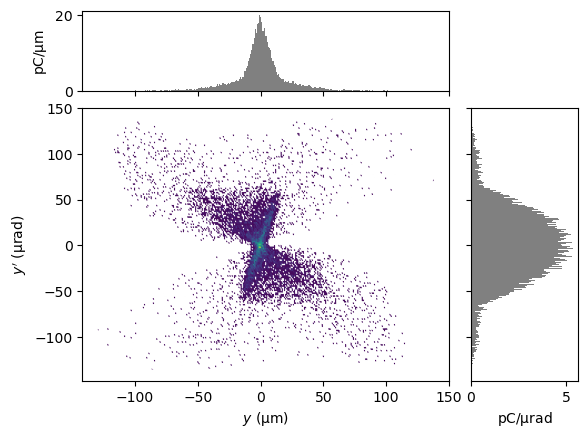

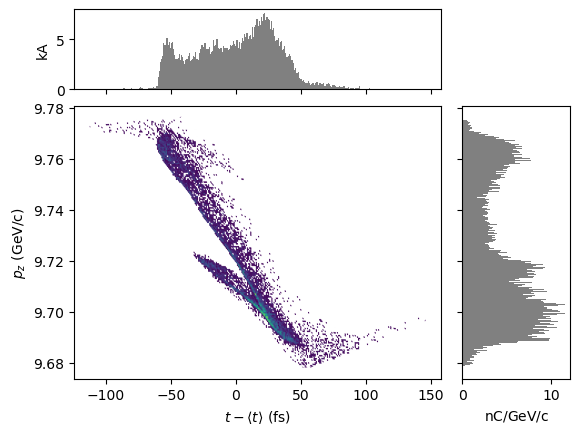

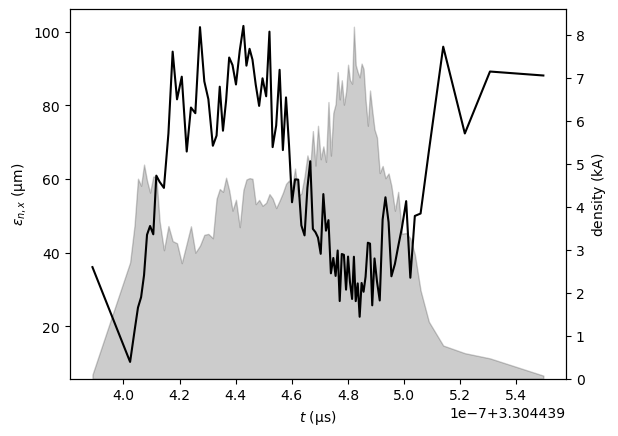

In [9]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'delta_t', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


P, sigma x: 5.8083288966391606e-05
PDrive, sigma x: 5.461124742381961e-05
PWitness, sigma x: 6.051703316279178e-05


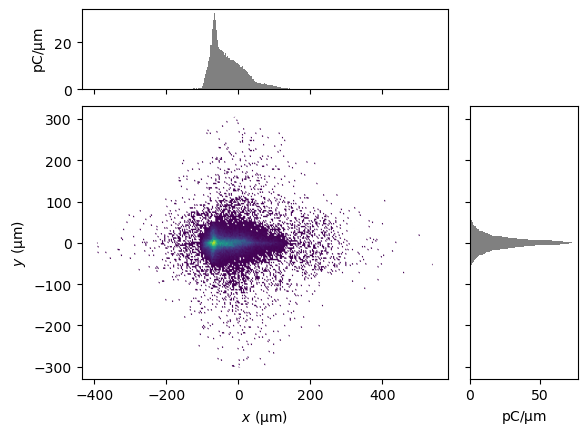

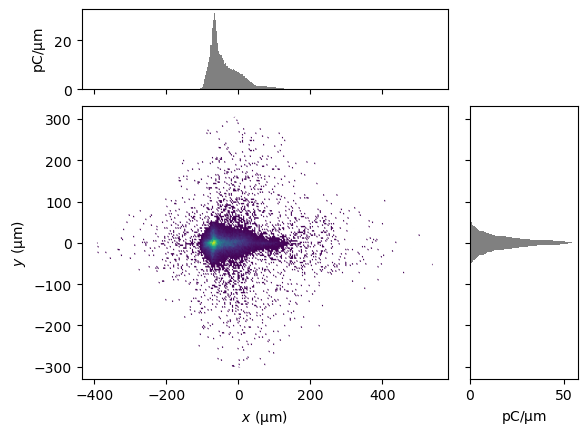

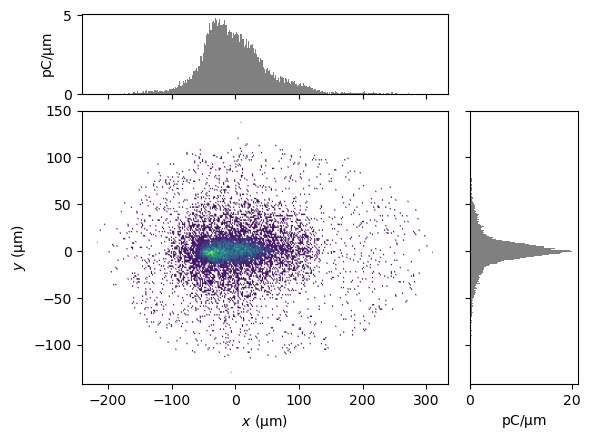

In [10]:
print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'y',  bins=300))